## SVM on HOG features

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray();

import sys
import numpy as np
sys.path.append('../scripts')
import datasets

#### Cluster definition and Initialization

In [2]:
from ipyparallel import Client
client = Client()
lb_view = client.load_balanced_view()

#### Model definition

In [3]:
from sklearn.svm import SVC
model = SVC()
model_keyword='hog_svm'
svc_params = {
    'C': np.logspace(-3, 2, 6),
    'gamma': np.logspace(-4, 2, 5),
    'kernel':['linear','rbf']
}

In [4]:
from sklearn.datasets import load_digits
from mmap_utils import persist_cv_splits
from sklearn.preprocessing import StandardScaler

data=datasets.load_cifar_hog()
scaler = StandardScaler()
X_train = scaler.fit_transform(data.X_train)
X_test = scaler.transform(data.X_test)
Y_train= data.y_train
Y_test= data.y_test

digits_split_filenames = persist_cv_splits(X_train, Y_train,
    name=model_keyword, random_state=4)

In [5]:
import model_selection
search = model_selection.RandomizedGridSeach(lb_view)
search.launch_for_splits(model, svc_params, digits_split_filenames)

Progress: 00% (000/180)

In [22]:
print(search.report())

Progress: 82% (149/180)

Rank 1: validation: 0.40571 (+/-0.00014) train: 0.63372 (+/-0.00097):
 {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.0031622776601683794}
Rank 2: validation: 0.39349 (+/-0.00073) train: 0.46851 (+/-0.00051):
 {'kernel': 'rbf', 'C': 100.0, 'gamma': 0.0001}
Rank 3: validation: 0.38709 (+/-0.00206) train: 0.99969 (+/-0.00004):
 {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.0031622776601683794}
Rank 4: validation: 0.38659 (+/-0.00208) train: 1.00000 (+/-0.00000):
 {'kernel': 'rbf', 'C': 100.0, 'gamma': 0.0031622776601683794}
Rank 5: validation: 0.37219 (+/-0.00104) train: 0.40310 (+/-0.00095):
 {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.0001}


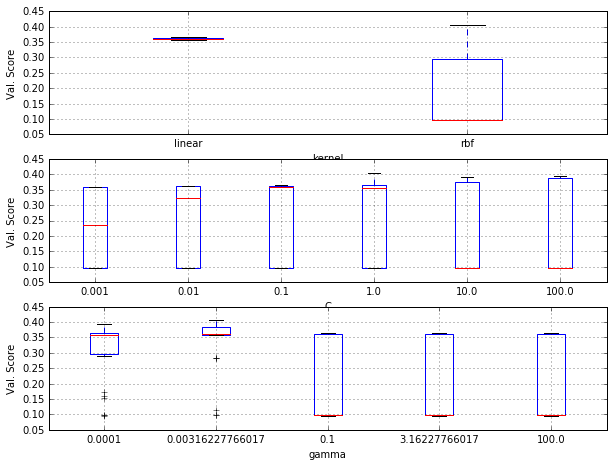

In [20]:
search.boxplot_parameters(display_train=False)

In [196]:
modfile='../models/'+model_keyword+'.pkl'
params=search.find_bests(1)[0][-1]
params

{'C': 1.0, 'gamma': 0.0031622776601683794, 'kernel': 'rbf'}

In [199]:
lb_view.abort()

In [202]:
# mod=search.save_best_model(X_train,Y_train,modfile)
def save_model(model,params,X_train,Y_train):
    model.set_params(**params)
    l=model.fit(X_train,Y_train)
    return l

In [203]:
mod=save_model(model,search.find_bests(1)[0][-1],X_train,Y_train)

In [204]:
from sklearn.externals import joblib
joblib.dump(mod,modfile)

['../models/hog_svm.pkl',
 '../models/hog_svm.pkl_01.npy',
 '../models/hog_svm.pkl_02.npy',
 '../models/hog_svm.pkl_03.npy',
 '../models/hog_svm.pkl_04.npy',
 '../models/hog_svm.pkl_05.npy',
 '../models/hog_svm.pkl_06.npy',
 '../models/hog_svm.pkl_07.npy',
 '../models/hog_svm.pkl_08.npy',
 '../models/hog_svm.pkl_09.npy',
 '../models/hog_svm.pkl_10.npy',
 '../models/hog_svm.pkl_11.npy']

In [206]:
classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Y_pred=mod.predict(X_test)

In [208]:
from sklearn.metrics import accuracy_score
print 'Performance on Test set: %0.2f'% (accuracy_score(Y_test,Y_pred))

Performance on Test set: 0.42


Classification Statistics:
             precision    recall  f1-score   support

   airplane       0.53      0.51      0.52      1000
 automobile       0.44      0.47      0.45      1000
       bird       0.43      0.35      0.38      1000
        cat       0.31      0.31      0.31      1000
       deer       0.38      0.34      0.36      1000
        dog       0.34      0.34      0.34      1000
       frog       0.40      0.49      0.44      1000
      horse       0.46      0.41      0.43      1000
       ship       0.49      0.54      0.51      1000
      truck       0.40      0.41      0.40      1000

avg / total       0.42      0.42      0.41     10000



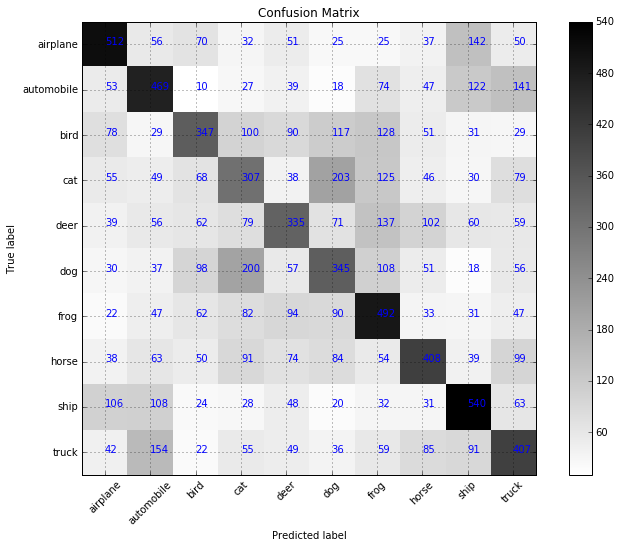

In [210]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print 'Classification Statistics:'
print classification_report(Y_test,Y_pred,target_names=classes)

conf = confusion_matrix(Y_test, Y_pred)
plt.imshow(conf, cmap='binary',interpolation='nearest')
plt.title('Confusion Matrix'); plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45);plt.yticks(tick_marks, classes)
plt.tight_layout();plt.ylabel('True label');plt.xlabel('Predicted label')
font = {'color':  'blue','stretch':'extra-expanded','weight':0,'size': 10}
for i,j in [(n,m) for n in range(len(classes)) for m in range(len(classes))]:
    plt.text(j,i,str(conf[i,j]),font)
